# Transferring styles to images

In the last couple of years, transferring styles from one image to another has had an enormous boost thanks to deep learning. Many people have experimented with transferring a certain style, often from a well-known painter, to a photo. The resulting images are often interesting to see because they show a mix between the painter's style and the original image. In the following example , we will show you how to use pretrained weights from VGG16 to transfer the style of one image to another.

In [1]:
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt

from keras.applications import vgg16 as trained_model
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K

Using TensorFlow backend.


### Next, we load the two images that we will use for style transfer and plot them: 

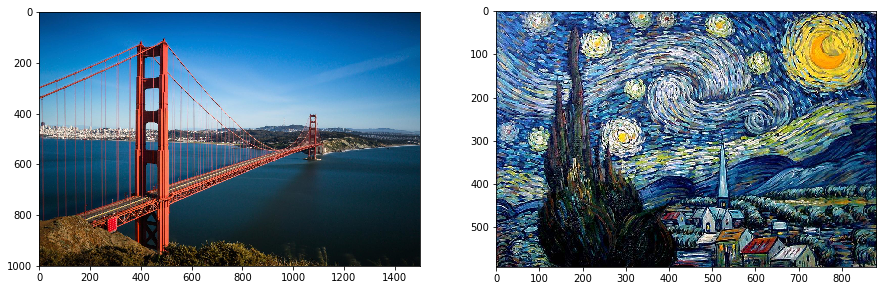

In [2]:
base_image_path = 'data/golden_gate.jpg'
style_reference_image_path = 'data/starry_night.jpg'

width, height = load_img(base_image_path).size
img_rows = 400
img_cols = 600
img_channels = 3

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
img = load_img(base_image_path)
plt.imshow(img)
plt.subplot(2, 2, 2)
img = load_img(style_reference_image_path)
plt.imshow(img)
plt.show()

### Define two functions that can preprocess and process images: 

In [3]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_rows, img_cols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = trained_model.preprocess_input(img)
    return img

def deprocess_image(x):
    x = x.reshape((img_rows, img_cols, img_channels))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Define the placeholders we need for training:

In [4]:
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_rows, img_cols, 3))
input_tensor = K.concatenate([base_image, style_reference_image, combination_image], axis=0)

### Import the VGG16 model and create a dict for the model's architecture:

In [5]:
model = trained_model.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
model_dict = dict([(layer.name, layer.output) for layer in model.layers])

58892288/58889256 [==============================] - 4s 0us/step


### For our style transfer, we need three different loss functions:

In [6]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_rows * img_cols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def total_variation_loss(x):
    a = K.square(x[:, :img_rows - 1, :img_cols - 1, :] - x[:, 1:, :img_cols - 1, :])
    b = K.square(x[:, :img_rows - 1, :img_cols - 1, :] - x[:, :img_rows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

### Define the hyperparameters:

In [7]:
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.25
n_iterations = 10

### Next, we need to create placeholder functions to determinethe losses during training:

In [8]:
loss = K.variable(0.)
layer_features = model_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features, combination_features)

feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
for layer_name in feature_layers:
    layer_features = model_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

### Define functions to evaluate the losses:

In [9]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_rows, img_cols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

###  Let's start the style transfer and plot the results for each iteration:

Iteration 0: loss value 12521225216.0


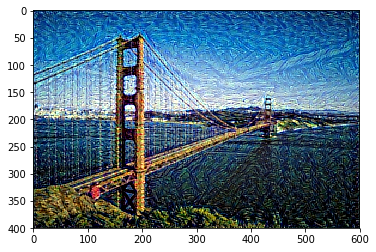

Iteration 1: loss value 10313793536.0


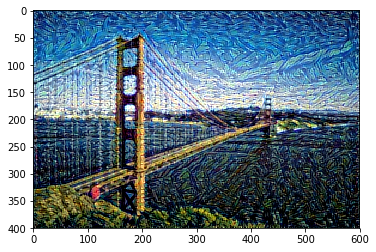

Iteration 2: loss value 9856490496.0


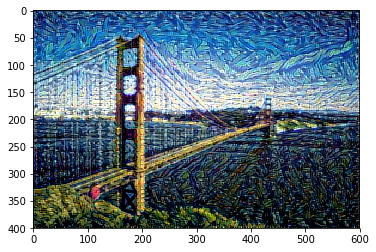

Iteration 3: loss value 9683556352.0


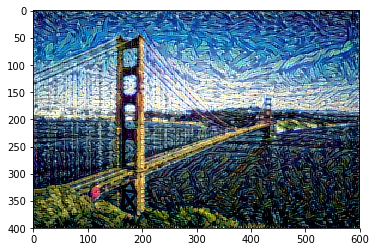

Iteration 4: loss value 9581103104.0


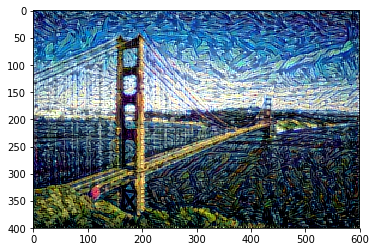

Iteration 5: loss value 9518452736.0


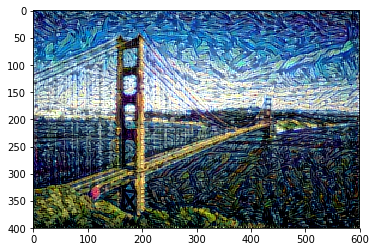

Iteration 6: loss value 9471379456.0


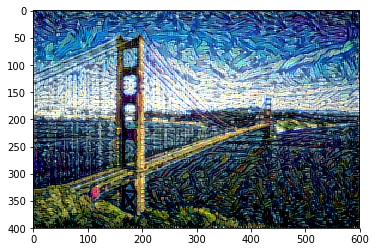

Iteration 7: loss value 9442098176.0


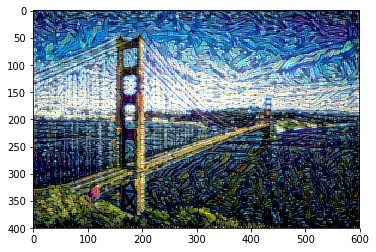

Iteration 8: loss value 9417388032.0


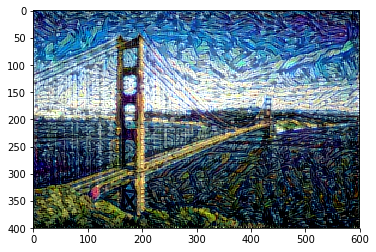

Iteration 9: loss value 9398261760.0


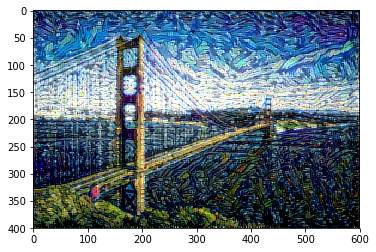

In [10]:
x = preprocess_image(base_image_path)

for i in range(n_iterations):
    x, min_val, _ = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Iteration {}: loss value {}'.format(i, min_val))
    img = deprocess_image(x.copy())
    plt.imshow(img)
    plt.show()